### Import Libraries

In [1]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import pickle
import mxnet as mx
from mxnet import recordio
from mxnet import ndarray as nd

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
torch.set_printoptions(edgeitems=5)

### Rough

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
device

device(type='cuda')

### Step 1a) Fetch the LFW dataset

#### Option ii) Fetch the sklearn library LFW dataset

In [49]:
idx = 0
pair = pairs[idx]
t = torch.from_numpy(pair)
print(t.shape)
t2 = torch.permute(t, (0, 3, 1, 2))
print(t2.shape)

tra = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
     ])
img1 = pair[0]
img2 = pair[1]

#img1 = img1.astype(int)
img1 = img1/255
img2 = img2/255

print(img1.shape)
t3 = tra(img1)
print(t3.shape)

t4 = tra(img2)

torch.Size([2, 125, 94, 3])
torch.Size([2, 3, 125, 94])
(125, 94, 3)
torch.Size([3, 125, 94])


In [50]:
torch.max(t3), torch.min(t3)

(tensor(1.), tensor(-1.))

In [51]:
new_pair = torch.stack((t3, t4), 0)
new_pair.shape

torch.Size([2, 3, 125, 94])

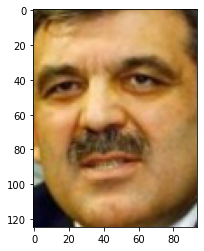

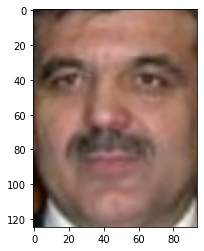

actual:  1


In [52]:
for idx in range(1000):
    pair = pairs[idx]
    img1 = pair[0]
    img2 = pair[1]

    plt.imshow(img1/255)
    plt.show()

    plt.imshow(img2/255)
    plt.show()

    print("actual: ", targets[idx])
    break

#### Option iii) Fetch the mx LFW dataset

In [53]:
with open(path, 'rb') as f:
            bins, issame_list = pickle.load(f, encoding='bytes')

In [54]:
len(issame_list), issame_list[3000]

(6000, True)

In [55]:
#Count no.of TRUE and FALSE verification pairs
same_list = [int(elem) for elem in issame_list]
same_list = np.array(same_list)
np.count_nonzero(same_list==1)

3000

In [56]:
len(bins), len(issame_list)

(12000, 6000)

(112, 112, 3)
(112, 112, 3)


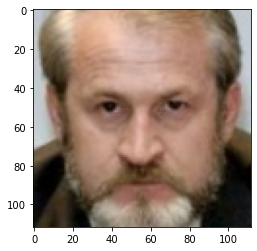

In [57]:
t = bins[2]
t2 = mx.image.imdecode(t)
print(t2.shape)
tt = t2.asnumpy()
print(tt.shape)

plt.imshow(tt)
plt.show()
#plt.title('label = ' + str(label.item()))

(112, 112, 3)
(112, 112, 3)


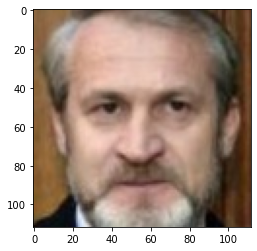

In [58]:
t = bins[3]
t2 = mx.image.imdecode(t)
print(t2.shape)
tt = t2.asnumpy()
print(tt.shape)

plt.imshow(tt)
plt.show()
#plt.title('label = ' + str(label.item()))

In [59]:
def load_bin(path, image_size=[112, 112]):
    with open(path, 'rb') as f:
        bins, issame_list = pickle.load(f, encoding='bytes')  # py3
    data_list = torch.empty((len(issame_list) * 2, 3, image_size[0], image_size[1]))
    
    for idx in range(len(issame_list) * 2):
        _bin = bins[idx]
        img = mx.image.imdecode(_bin)
        if img.shape[1] != image_size[0]:
            img = mx.image.resize_short(img, image_size[0])
        img = np.transpose(img, axes=(2, 0, 1))
        data_list[idx][:] = torch.from_numpy(img.asnumpy())
        
        if idx % 1000 == 0:
            print('loading bin', idx)
    print(data_list.shape, len(issame_list))
    return data_list, issame_list

In [60]:
x, y = load_bin(path)

loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
torch.Size([12000, 3, 112, 112]) 6000


In [61]:
for i in range(12000):
    img1 = x[i]
    img2 = x[i+1]
    print(img1.shape)
    break

torch.Size([3, 112, 112])


True


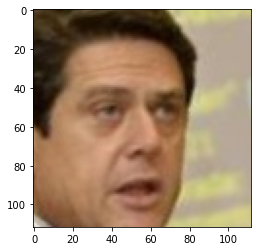

In [62]:
img = x[120]
img = torch.permute(img, (1, 2, 0))
print(y[120])

plt.imshow(img/255)
plt.show()

In [63]:
computed_scores = compute_scores(pairs, targets)
print(computed_scores.shape)
print(computed_scores)

torch.Size([1000])
tensor([0.2588, 0.2342, 0.2115, 0.3004, 0.2399, 0.2458, 0.2597, 0.2505, 0.2399,
        0.2172, 0.2989, 0.2518, 0.2362, 0.2430, 0.2419, 0.3300, 0.2703, 0.2422,
        0.2746, 0.2713, 0.2392, 0.2106, 0.2234, 0.2150, 0.2059, 0.1872, 0.2396,
        0.2181, 0.2355, 0.2202, 0.3188, 0.2490, 0.2461, 0.2477, 0.2806, 0.2928,
        0.2465, 0.2761, 0.3217, 0.3383, 0.2542, 0.2501, 0.2298, 0.2579, 0.2362,
        0.2322, 0.2329, 0.2900, 0.2131, 0.2569, 0.2436, 0.2515, 0.2325, 0.2548,
        0.2518, 0.2293, 0.2312, 0.2171, 0.2160, 0.2376, 0.2380, 0.2867, 0.3254,
        0.2670, 0.2507, 0.1963, 0.2094, 0.2713, 0.2708, 0.2642, 0.2048, 0.2447,
        0.2014, 0.2320, 0.2664, 0.2356, 0.2056, 0.2584, 0.2464, 0.2780, 0.1873,
        0.2580, 0.3232, 0.2304, 0.2719, 0.2282, 0.3313, 0.2583, 0.2461, 0.2369,
        0.2540, 0.2967, 0.2609, 0.2758, 0.2305, 0.3030, 0.2146, 0.2540, 0.2371,
        0.2913, 0.2567, 0.3064, 0.1926, 0.2211, 0.2383, 0.2078, 0.2197, 0.2161,
        0.2736, 0.283

In [64]:
torch.min(computed_scores), torch.max(computed_scores)

(tensor(0.1396), tensor(0.3763))

In [65]:
thresholds = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
ver_accuracy(computed_scores, targets, thresholds)

Thres:  0.01 | Veri acc.:  50.0
Thres:  0.03 | Veri acc.:  50.0
Thres:  0.05 | Veri acc.:  50.0
Thres:  0.1 | Veri acc.:  50.0
Thres:  0.2 | Veri acc.:  58.0
Thres:  0.3 | Veri acc.:  56.4


### Step 3) Testing the model - Option 2

In [66]:
def compute_scores2(img_pairs, img_targets):
    
    scores = []
    
    for idx in np.arange(0, 12000, 2):
        actual = img_targets[int(idx/2)]
        
        #convert pair to pytorch tensor, normalize
        img1 = img_pairs[idx]
        img1 = torch.permute(img1, (1, 2, 0))
        img1 = img1.numpy()
        img1 = img1/255
        img1 = tra(img1)
    
        img2 = img_pairs[idx+1]
        img2 = torch.permute(img2, (1, 2, 0))
        img2 = img2.numpy()
        img2 = img2/255
        img2 = tra(img2)
        
        #convert into a batch
        new_pair = torch.stack((img1, img2), 0).to(device)
        
        score = compute_embedding(loaded_model, new_pair, similarity)
        #print(actual, score.item())
        
        scores.append(score.item())
        #scores.append(np.abs(score.cpu()))
    
    scores = torch.FloatTensor(scores)
    #print(scores.shape, scores)
    
    return scores

In [ ]:
targets = np.array(issame_list)
#print(targets)
targets = targets.astype(int)
#print(targets)
#targets_tensor = torch.from_numpy(targets)